In [1]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import re
# !pip install transformers
from transformers import BertModel, BertTokenizer
from torch import cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
pip install pytorch-lightning

In [3]:
import pytorch_lightning as pl

In [4]:
url = 'https://raw.githubusercontent.com/yasaswinik12/LSTM_datasets/main/tamil_offensive_full_train.csv?token=AOSGB3LH4OW2T2DFG2XVFKK743LWC'
df = pd.read_csv(url, delimiter='\t', names=['sentence','classes','nan'])
df = df.drop(columns=['nan'])
df.head(9)

,sentence,classes
0,movie vara level la Erika poguthu,Not_offensive
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,not-Tamil
2,Padam nalla comedy padama irukum polaye..,Not_offensive
3,karthick subburaj anne .... intha padam vetri ...,Not_offensive
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,Not_offensive
5,ippo intha trailer ah parkuravana oru like pod...,Not_offensive
6,En thalaivan yogi babu irukkaar. Padam vera le...,Not_offensive
7,Nerkonda parvai... Sema sema sema trailer,Not_offensive
8,ஏய் இது 96 யார் ஏமாத்தறீங்க? செம பின்னிட்டீங்க,Not_offensive


In [5]:
df.count()

sentence    35139
classes     35139
dtype: int64

In [6]:
df['classes'].apply(len).max()

36

In [7]:
df['sentence'].apply(len).max()

1149

In [8]:
df['classes'].unique()

array(['Not_offensive', 'not-Tamil', 'Offensive_Targeted_Insult_Other',
       'Offensive_Targeted_Insult_Group', 'Offensive_Untargetede',
       'Offensive_Targeted_Insult_Individual'], dtype=object)

In [9]:
encode_dict = {}

def encode_cat(x):
  if x not in encode_dict.keys():
    encode_dict[x] = len(encode_dict)
  return encode_dict[x]

df['encode_cat'] = df['classes'].apply(lambda x: encode_cat(x))
df.head(9)

,sentence,classes,encode_cat
0,movie vara level la Erika poguthu,Not_offensive,0
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,not-Tamil,1
2,Padam nalla comedy padama irukum polaye..,Not_offensive,0
3,karthick subburaj anne .... intha padam vetri ...,Not_offensive,0
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,Not_offensive,0
5,ippo intha trailer ah parkuravana oru like pod...,Not_offensive,0
6,En thalaivan yogi babu irukkaar. Padam vera le...,Not_offensive,0
7,Nerkonda parvai... Sema sema sema trailer,Not_offensive,0
8,ஏய் இது 96 யார் ஏமாத்தறீங்க? செம பின்னிட்டீங்க,Not_offensive,0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


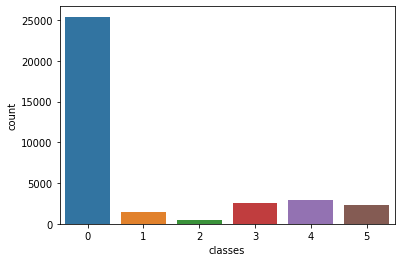

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(df.encode_cat)
plt.xlabel('classes');

In [11]:
df['sentence'] = df['sentence'].apply(lambda x: x.lower())
df['sentence'] = df['sentence'].apply(lambda x: re.sub(r' +', ' ',x))
df['sentence'] = df['sentence'].apply(lambda x: re.sub("[!@#$+%*:()'-]", ' ',x))
df['sentence'] = df['sentence'].str.replace('\d+', '')

In [12]:
df['sentence'].apply(len).max()

1124

In [ ]:
# import imblearn
# from collections import Counter
# from matplotlib import pyplot
# X = df['sentence']
# y = df['encode_cat']
# counter = Counter(y)
# for k,v in counter.items():
# 	per = v / len(y) * 100
# 	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# # plot the distribution
# pyplot.bar(counter.keys(), counter.values())
# pyplot.show()

In [13]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5
bert_multilingual = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(bert_multilingual)

In [14]:
class SentimentDataset(Dataset):

  def __init__(self,sentence,encode_cat,tokenizer,max_len):
    self.len = len(sentence)
    self.sentence = sentence
    self.encode_cat = encode_cat
    self.tokenizer = tokenizer
    self.max_len = max_len 
  

  def __getitem__(self,index):
    sentence = str(self.sentence[index])
    sentence = " ".join(sentence.split())
    encoding = self.tokenizer.encode_plus(
        sentence,
        add_special_tokens = True,
        max_length = self.max_len,
        padding = 'max_length',
        return_token_type_ids = False,
        return_tensors = 'pt',
        truncation = True
    )
    #ids = encoding['input_ids']
    #mask = encoding['attention_mask']
    return {
        'ids' : encoding['input_ids'].flatten(),
        'mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(self.encode_cat[index],dtype=torch.long)
    }

  def __len__(self):
    return self.len

In [15]:
train_size = 0.9
train_dataset = df.sample(frac=train_size,random_state=42).reset_index(drop=True)
test_dataset = df.drop(train_dataset.index).reset_index(drop=True)
# train_dataset = train_dataset.reset_index(drop=True)

print('Total no of entities in the dataset: {}'.format(df.shape))
print('Train dataset:{}'.format(train_dataset.shape))
print('Test dataset: {}'.format(test_dataset.shape))

# training_set = SentimentDataset(train_dataset,tokenizer,MAX_LEN)
# testing_set = SentimentDataset(test_dataset,tokenizer,MAX_LEN)

Total no of entities in the dataset: (35139, 3)
Train dataset:(31625, 3)
Test dataset: (3514, 3)


In [16]:
# training_set = SentimentDataset(sentence=train_dataset['sentence'],
#       encode_cat=train_dataset['encode_cat'],
#       tokenizer=tokenizer,
#       max_len=MAX_LEN)
# testing_set = SentimentDataset(sentence=test_dataset['sentence'],
#       encode_cat=test_dataset['encode_cat'],
#       tokenizer=tokenizer,
#       max_len=MAX_LEN)
                               

In [ ]:
# train_params = {'batch_size': TRAIN_BATCH_SIZE,
#                 'shuffle': True,
#                 'num_workers': 0
#                 }

# test_params = {'batch_size': VALID_BATCH_SIZE,
#                 'shuffle': True,
#                 'num_workers': 0
#                 }

# training_loader = DataLoader(training_set, **train_params)
# testing_loader = DataLoader(testing_set, **test_params)

In [17]:
weights = [0.28, 0.96, 0.99, 0.93, 0.92, 0.94]
w = torch.tensor(weights)

In [19]:
class BERTClass(pl.LightningModule):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 6)

        self.loss = nn.CrossEntropyLoss(weight= w)
        
    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

    def configure_optimizers(self):
        optimizer = optim.Adam(params= self.parameters(),lr = LEARNING_RATE)
        return optimizer

    def training_step(self, batch, batch_idx):
         ids = batch['ids']
         mask = batch['mask']
         targets = batch['targets']
      
         outputs = self(ids, mask)
         loss = self.loss(outputs, targets)
      #  tr_loss += loss.item()
         big_val, big_idx = torch.max(outputs.data, dim=1)
         n_correct += calcuate_accuracy(big_idx, targets)

         nb_tr_steps += 1
         nb_tr_examples+=targets.size(0)
      
      #  optimizer.zero_grad()
         loss.backward()
      #When using GPU
      #  optimizer.step()
         return {'loss' : loss}

    def train_dataloader(self):
         training_set = SentimentDataset(sentence=train_dataset['sentence'],
                encode_cat=train_dataset['encode_cat'],
                tokenizer=tokenizer,
                max_len=MAX_LEN)
         train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
         training_loader = DataLoader(training_set, **train_params)
         return training_loader

model = BERTClass()


In [20]:
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1)
trainer.fit(model)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | l1             | BertModel        | 177 M 
1 | pre_classifier | Linear           | 590 K 
2 | dropout        | Dropout          | 0     
3 | classifier     | Linear           | 4.6 K 
4 | loss           | CrossEntropyLoss | 0     
----------------------------------------------------
178 M     Trainable params
0         Non-trainable params
178 M     Total params


UnboundLocalError: ignored

In [ ]:
weights = [0.28, 0.96, 0.99, 0.93, 0.92, 0.94]
w = torch.tensor(weights)

In [ ]:
loss_function = nn.CrossEntropyLoss(weight= w).to(device)
optimizer = optim.Adam(params= model.parameters(),lr = LEARNING_RATE)

In [ ]:
def calcuate_accuracy(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
seed_val = 42
torch.manual_seed(seed_val)

In [ ]:
def train(epoch):
  
  tr_loss = 0
  n_correct = 0
  nb_tr_steps = 0
  nb_tr_examples = 0
  model.train()
  start_time = time.time()
  for _,data in enumerate(training_loader, 0):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.long)

      outputs = model(ids, mask)
      loss = loss_function(outputs, targets)
      tr_loss += loss.item()
      big_val, big_idx = torch.max(outputs.data, dim=1)
      n_correct += calcuate_accuracy(big_idx, targets)

      nb_tr_steps += 1
      nb_tr_examples+=targets.size(0)
      
      optimizer.zero_grad()
      loss.backward()
      #When using GPU
      optimizer.step()

  print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
  epoch_loss = tr_loss/nb_tr_steps
  epoch_accu = (n_correct*100)/nb_tr_examples
  print(f"Training Loss Epoch: {epoch_loss}")
  print(f"Training Accuracy Epoch: {epoch_accu}")
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')

  return

In [ ]:
for epoch in range(EPOCHS):
  train(epoch)
  print()

RuntimeError: ignored

In [ ]:
def valid(model,testing_loader):
  model.eval()
  n_correct = 0
  n_wrong = 0
  total = 0
  tr_loss = 0
  nb_tr_steps = 0
  nb_tr_examples = 0
  with torch.no_grad():
    for _,data in enumerate(testing_loader,0):
      ids = data['ids'].to(device,dtype = torch.long)
      mask = data['mask'].to(device,dtype = torch.long)
      targets = data['targets'].to(device,dtype=torch.long)
      outputs = model(ids,mask).squeeze()
      loss = loss_function(outputs,targets)
      tr_loss += loss.item()
      big_val,big_idx = torch.max(outputs.data,dim=1)
      n_correct += calcuate_accuracy(big_idx,targets)
      nb_tr_steps += 1
      nb_tr_examples += targets.size(0)

    epoch_loss = tr_loss/nb_tr_steps
    epoch_accuracy = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch:{epoch_loss}")
    print(f"Validation Accuracy Epoch:{epoch_accuracy}")

    return epoch_accuracy

In [ ]:
acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      #texts = d["sentences"]
      ids = d["ids"].to(device)
      mask = d["mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=ids,
        attention_mask=mask
      )
      _, preds = torch.max(outputs, dim=1)
      #sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,testing_loader)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred,zero_division=0))